## Demo NB to show the TOF electronics computing

In [2]:
import sys
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import antea.elec.tof_functions as tf

from antea.io.mc_io import load_mcTOFsns_response

#### Parameters

In [3]:
SIPM        = {'n_sipms':3500, 'first_sipm':1000, 'tau_sipm':[100,15000]}
n_sipms     = SIPM['n_sipms']
first_sipm  = SIPM['first_sipm']
tau_sipm    = SIPM['tau_sipm']
TE_range    = [0.25]
TE_TDC      = TE_range[0]
time_window = 10000
time_bin    = 5
time        = np.arange(0, 80000, time_bin)
spe_resp    = tf.spe_dist(tau_sipm, time)

In [5]:
#np.set_printoptions(threshold=sys.maxsize)
file_name      = '/Users/carmenromoluque/nexus_petit_analysis/PETit-ring/DAQ_antea/petit_ring_tof_high_stat.000.pet.h5'
tof_response   = load_mcTOFsns_response(file_name)
tof_waveforms  = tof_response[tof_response.event_id == 0]
tdc_conv_table = tf.tdc_convolution(tof_waveforms, spe_resp, time_window, n_sipms, first_sipm, TE_TDC)
tof_table      = np.zeros((time_window  + len(spe_resp)-1, n_sipms))

In [7]:
## This function returns the same matrix but for the TOF discrete case (no distribution added)
def no_convolve_tof(spe_resp, signal):
    no_conv_zeros = np.zeros(len(spe_resp)-1)
    no_conv_first = np.hstack([1., no_conv_zeros, np.zeros(len(signal)-1)])
    no_conv_res   = np.zeros(len(spe_resp)+len(signal)-1)
    pe_pos        = np.argwhere(signal > 0)
    pe_recov      = signal[pe_pos]
    for i in range(len(pe_recov)):
        desp     = np.roll(no_conv_first, pe_pos[i])
        no_conv_res = desp + no_conv_res
    return no_conv_res

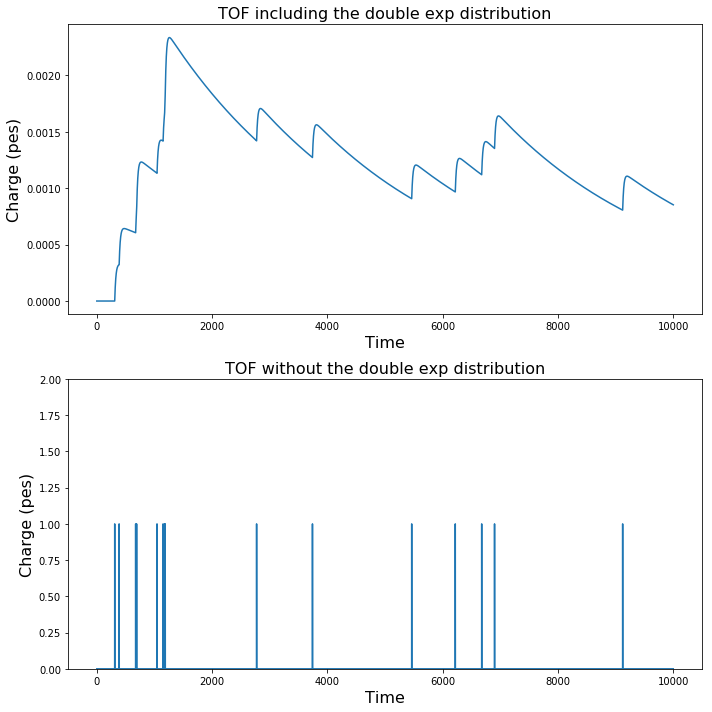

12.515290570182893
15.0


In [10]:
tof_wave  = load_mcTOFsns_response(file_name)
for evt in range(1):
    tof_waveforms = tof_wave[tof_wave.event_id == evt]
    pe_table  = np.zeros((time_window, n_sipms))
    for i, wf in tof_waveforms.iterrows():
        if wf.time_bin < time_window:
            s_id = - wf.sensor_id - first_sipm
            pe_table[wf.time_bin, s_id] = wf.charge
            
    conv_table    = np.zeros((len(pe_table) + len(spe_resp)-1, n_sipms))
    no_conv_table = np.zeros((len(pe_table) + len(spe_resp)-1, n_sipms))
    
    #for i in range(n_sipms):
    for i in range(91, 92):
        if np.count_nonzero(pe_table[0:time_window,i]):
            conv_table[:,i]    = tf.convolve_tof(spe_resp, pe_table[0:time_window,i])
            zeros_spe_resp     = np.zeros(len(spe_resp))
            no_conv_table[:,i] = no_convolve_tof(zeros_spe_resp, pe_table[0:time_window,i])
            
            fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,10))
            ax1.plot(np.arange(0,time_window), conv_table[:time_window,i])
            ax2.plot(np.arange(0,time_window), no_conv_table[:time_window,i])
            #ax1.set_ylim(0,2)
            ax2.set_ylim(0,2)
            ax1.set_ylabel('Charge (pes)', size=16)
            ax2.set_ylabel('Charge (pes)', size=16)
            ax1.set_xlabel('Time', size=16)
            ax2.set_xlabel('Time', size=16)
            ax1.set_title('TOF including the double exp distribution', size=16)
            ax2.set_title('TOF without the double exp distribution', size=16)
            plt.tight_layout()
            plt.show()

            print(np.sum(conv_table   [:time_window,i]))
            print(np.sum(no_conv_table[:time_window,i]))

### Translation from the matrix to a tof_waveform dataframe

In [12]:
for evt in range(1):
    tof_waveforms = tof_wave[tof_wave.event_id == evt]
    pe_table  = np.zeros((time_window, n_sipms))
    for i, wf in tof_waveforms.iterrows():
        if wf.time_bin < time_window:
            s_id = - wf.sensor_id - first_sipm
            pe_table[wf.time_bin, s_id] = wf.charge
            
    conv_table    = np.zeros((len(pe_table) + len(spe_resp)-1, n_sipms))
    no_conv_table = np.zeros((len(pe_table) + len(spe_resp)-1, n_sipms))
    
    #for i in range(n_sipms):
    for i in range(91, 92):
        if np.count_nonzero(pe_table[0:time_window,i]):
            conv_table[:,i]    = tf.convolve_tof(spe_resp, pe_table[0:time_window,i]) ##len(conv_table[:,i]) = 25999
        list_wf = []
        for t in range(len(conv_table)):
            for s_id in range(conv_table.shape[1]):
                charge = conv_table[t,s_id]
                s_id = - s_id - first_sipm
                if charge > 0.:
                    list_wf.append(np.array([evt, s_id, t, charge]))
        a_wf = np.array(list_wf)
        keys = np.array(['event_id', 'sensor_id', 'time_bin', 'charge'])
        df = pd.DataFrame(a_wf, columns = keys) 
    print(df.head())
     

   event_id  sensor_id  time_bin    charge
0       0.0    -1091.0     312.0  0.000016
1       0.0    -1091.0     313.0  0.000032
2       0.0    -1091.0     314.0  0.000047
3       0.0    -1091.0     315.0  0.000061
4       0.0    -1091.0     316.0  0.000074
